<a href="https://colab.research.google.com/github/ahmed-tbe/bilayer-graphene/blob/main/C_F_bond_count.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

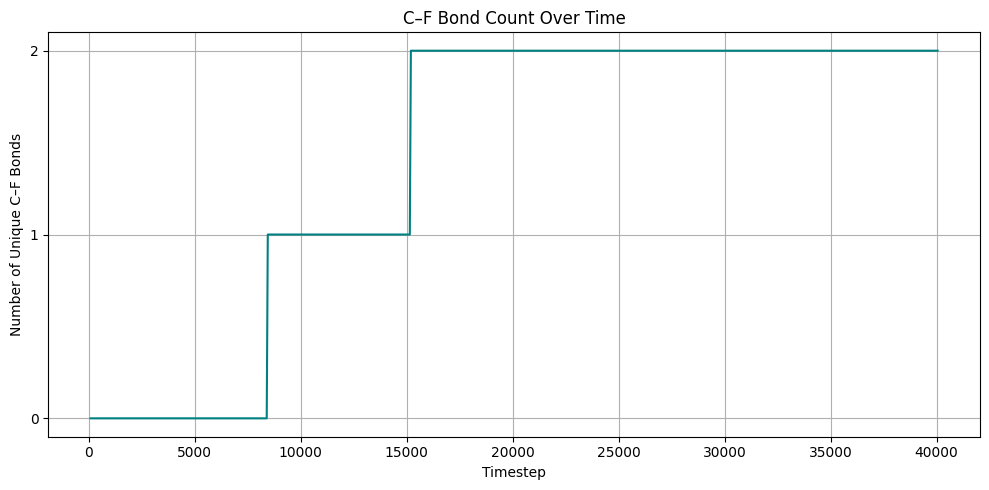

In [ ]:
from collections import defaultdict

file_path = "bonds.reax"
BOND_ORDER_CUTOFF = 0.3
CARBON_TYPE = 1
FLUORINE_TYPE = 2

cf_bond_counts = defaultdict(int)

def process_timestep(timestep, atoms):
    """Counts unique C–F bonds for a given timestep."""
    id_type_map = {int(a[0]): int(a[1]) for a in atoms}
    cf_bonds = set()

    for a in atoms:
        atom_id = int(a[0])
        atom_type = int(a[1])
        num_neighbors = int(a[2])

        if num_neighbors == 0:
            continue

        neighbor_ids = list(map(int, a[3:3 + num_neighbors]))
        bond_orders = list(map(float, a[3 + num_neighbors:3 + 2 * num_neighbors]))

        for neighbor_id, bond_order in zip(neighbor_ids, bond_orders):
            neighbor_type = id_type_map.get(neighbor_id)
            if bond_order > BOND_ORDER_CUTOFF:
                # Check for C-F bond (either direction)
                if (atom_type == CARBON_TYPE and neighbor_type == FLUORINE_TYPE) or \
                   (atom_type == FLUORINE_TYPE and neighbor_type == CARBON_TYPE):
                    bond_pair = tuple(sorted((atom_id, neighbor_id)))
                    cf_bonds.add(bond_pair)

    cf_bond_counts[timestep] = len(cf_bonds)

# Read and parse file
with open(file_path, 'r') as f:
    lines = f.readlines()

timestep = None
atoms = []

for line in lines:
    line = line.strip()
    if not line:
        continue
    if line.startswith("# Timestep"):
        if timestep is not None:
            process_timestep(timestep, atoms)
        timestep = int(line.split()[-1])
        atoms = []
    elif not line.startswith("#"):
        split_line = line.split()
        if len(split_line) < 3:
            print(f"⚠️ Unexpected line format at timestep {timestep}: {line}")
            continue
        atoms.append(split_line)

# Process last timestep
if timestep is not None:
    process_timestep(timestep, atoms)

# Output results
#for ts in sorted(cf_bond_counts):
    #print(f"Timestep {ts}: {cf_bond_counts[ts]} unique C–F bonds")

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Sort the data
sorted_timesteps = sorted(cf_bond_counts.keys())
bond_values = [cf_bond_counts[ts] for ts in sorted_timesteps]

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(sorted_timesteps, bond_values, linestyle='-', color='teal')  # no markers
plt.xlabel("Timestep")
plt.ylabel("Number of Unique C–F Bonds")
plt.title("C–F Bond Count Over Time")
plt.grid(True)

# Force y-axis to use integer ticks only
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.tight_layout()
plt.show()
